# Averaging across realizations
## Using Google Cloud CMIP6 data

Historical period tas + relative humidity 
1950-2014: average per season

Import one of the other realizations (1 & 2 are contained in oen file, 10 and 11 are contained across 4 files)
concatenate across realizations, lining up tas values per month-year

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs
import cartopy.feature as cfeature
import seaborn  
import xarray as xr
import regionmask
import os
#this variable is only checked 
#at first import of GeoPandas.
#toggles on PYGEOS
#os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import earthpy 
import netCDF4 as nc
import cftime
#assists gpd with shp opening
import fiona #help(fiona.open)
import rasterio
import odc.geo.xr
#for clipping xarray 
import rioxarray as rio
from shapely.geometry import mapping
from shapely.geometry import Polygon
import rasterio
from affine import Affine
#import nc_time_axis
import cftime
from shapely.geometry import mapping, Polygon
import datetime
import warnings
from datetime import datetime, timedelta
#import regions
from osgeo import gdal,osr,ogr
import zarr
import fsspec

In [2]:
#retrieving directory
os.getcwd()
#'/Users/jenniferbadger/Documents/GitHub/CMIP6-SoCal'

'/Users/jenniferbadger/Documents/GitHub/CMIP6-SoCal'

In [3]:
#using this tutorial https://earth-env-data-science.github.io/lectures/models/cmip.html
# analysis-ready-cloud-optimized repositories of CMIP6 data
#maintained by the pangeo community
#publicly available on both Google Cloud 

from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics

In [4]:
#over 500k zarr stores of data
#Zarr is a storage format 
#for 'chunked' datasets - i.e. compressed
#that works well with xarray
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [5]:
#lists the experiments
#historical and ssp245 middle of the road
#are what I will use
col.df['experiment_id'].unique()

array(['highresSST-present', 'piControl', 'control-1950', 'hist-1950',
       'historical', 'amip', 'abrupt-4xCO2', 'abrupt-2xCO2',
       'abrupt-0p5xCO2', '1pctCO2', 'ssp585', 'esm-piControl', 'esm-hist',
       'hist-piAer', 'histSST-1950HC', 'ssp245', 'hist-1950HC', 'histSST',
       'piClim-2xVOC', 'piClim-2xNOx', 'piClim-2xdust', 'piClim-2xss',
       'piClim-histall', 'hist-piNTCF', 'histSST-piNTCF',
       'aqua-control-lwoff', 'piClim-lu', 'histSST-piO3', 'piClim-CH4',
       'piClim-NTCF', 'piClim-NOx', 'piClim-O3', 'piClim-HC',
       'faf-heat-NA0pct', 'ssp370SST-lowCH4', 'piClim-VOC',
       'ssp370-lowNTCF', 'piClim-control', 'piClim-aer', 'hist-aer',
       'faf-heat', 'faf-heat-NA50pct', 'ssp370SST-lowNTCF',
       'ssp370SST-ssp126Lu', 'ssp370SST', 'ssp370pdSST', 'histSST-piAer',
       'piClim-ghg', 'piClim-anthro', 'faf-all', 'hist-nat', 'hist-GHG',
       'ssp119', 'piClim-histnat', 'piClim-4xCO2', 'ssp370',
       'piClim-histghg', 'highresSST-future', 'esm-ssp585-

In [6]:
#shows this diff modeling groups
#NCAR Community Earth System Model
#is available here
col.df['source_id'].unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-HR',
       'ECMWF-IFS-LR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-ESM2M', 'GFDL-CM4C192', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'SAM0-UNICON',
       'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3', 'EC-Earth3-Veg',
       'FGOALS-f3-L', 'CanESM5', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-H', 'MRI-AGCM3-2-S',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

In [7]:
#temp at surface
#monthly interval
catalog_tas = col.search(
    variable_id='tas',
    table_id='Amon',
    source_id=['CESM2'],
)
catalog_tas

,unique
activity_id,10
institution_id,1
source_id,1
experiment_id,36
member_id,100
table_id,1
variable_id,1
grid_label,1
zstore,863
dcpp_init_year,0


In [8]:
catalog_tas.keys()

['C4MIP.NCAR.CESM2.1pctCO2-bgc.Amon.gn',
 'C4MIP.NCAR.CESM2.1pctCO2-rad.Amon.gn',
 'CFMIP.NCAR.CESM2.abrupt-0p5xCO2.Amon.gn',
 'CFMIP.NCAR.CESM2.abrupt-2xCO2.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-4xCO2.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-future4K.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-m4K.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-p4K.Amon.gn',
 'CMIP.NCAR.CESM2.1pctCO2.Amon.gn',
 'CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn',
 'CMIP.NCAR.CESM2.amip.Amon.gn',
 'CMIP.NCAR.CESM2.esm-hist.Amon.gn',
 'CMIP.NCAR.CESM2.esm-piControl.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.NCAR.CESM2.piControl.Amon.gn',
 'DAMIP.NCAR.CESM2.hist-GHG.Amon.gn',
 'DAMIP.NCAR.CESM2.hist-aer.Amon.gn',
 'DAMIP.NCAR.CESM2.hist-nat.Amon.gn',
 'GMMIP.NCAR.CESM2.amip-hist.Amon.gn',
 'LS3MIP.NCAR.CESM2.land-hist.Amon.gn',
 'LUMIP.NCAR.CESM2.deforest-globe.Amon.gn',
 'LUMIP.NCAR.CESM2.land-noLu.Amon.gn',
 'PAMIP.NCAR.CESM2.futSST-pdSIC.Amon.gn',
 'PAMIP.NCAR.CESM2.pdSST-futAntSIC.Amon.gn',
 'PAMIP.NCAR.CESM2.pdSST-futArcSIC.Amon.gn',

In [9]:
#temp at surface
#monthly interval
catalog_tas = col.search(
    variable_id='tas',
    table_id='Amon',
    experiment_id=['historical', 'ssp245'],
    source_id=['CESM2'],
)
catalog_tas


,unique
activity_id,2
institution_id,1
source_id,1
experiment_id,2
member_id,11
table_id,1
variable_id,1
grid_label,1
zstore,14
dcpp_init_year,0


In [10]:
#contains 11 realizations
catalog_tas.df['member_id'].unique()

array(['r1i1p1f1', 'r4i1p1f1', 'r5i1p1f1', 'r2i1p1f1', 'r3i1p1f1',
       'r6i1p1f1', 'r8i1p1f1', 'r7i1p1f1', 'r9i1p1f1', 'r10i1p1f1',
       'r11i1p1f1'], dtype=object)

In [11]:
catalog_tas.keys()

['CMIP.NCAR.CESM2.historical.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn']

In [12]:
#gn = native model grid
#more detail but also
#more complex than gr
#which is regridded
#to regular lat/lon intervals
#meaning 1-180 lon?
catalog_tas.df['grid_label'].unique()

array(['gn'], dtype=object)

In [13]:
#temp at surface
#monthly interval
catalog_hurs = col.search(
    variable_id='hurs',
    table_id='Amon',
    source_id=['CESM2'],
)
catalog_hurs

,unique
activity_id,8
institution_id,1
source_id,1
experiment_id,24
member_id,11
table_id,1
variable_id,1
grid_label,1
zstore,48
dcpp_init_year,0


In [14]:
catalog_hurs.keys()

['C4MIP.NCAR.CESM2.1pctCO2-bgc.Amon.gn',
 'C4MIP.NCAR.CESM2.1pctCO2-rad.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-4xCO2.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-future4K.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-m4K.Amon.gn',
 'CFMIP.NCAR.CESM2.amip-p4K.Amon.gn',
 'CFMIP.NCAR.CESM2.aqua-4xCO2.Amon.gn',
 'CFMIP.NCAR.CESM2.aqua-control.Amon.gn',
 'CFMIP.NCAR.CESM2.aqua-p4K.Amon.gn',
 'CMIP.NCAR.CESM2.1pctCO2.Amon.gn',
 'CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn',
 'CMIP.NCAR.CESM2.amip.Amon.gn',
 'CMIP.NCAR.CESM2.esm-piControl.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.NCAR.CESM2.piControl.Amon.gn',
 'DAMIP.NCAR.CESM2.hist-GHG.Amon.gn',
 'DAMIP.NCAR.CESM2.hist-nat.Amon.gn',
 'LS3MIP.NCAR.CESM2.land-hist.Amon.gn',
 'LUMIP.NCAR.CESM2.land-noLu.Amon.gn',
 'RFMIP.NCAR.CESM2.piClim-control.Amon.gn',
 'ScenarioMIP.NCAR.CESM2.ssp126.Amon.gn',
 'ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn',
 'ScenarioMIP.NCAR.CESM2.ssp370.Amon.gn',
 'ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn']

In [15]:
catalog_hurs = col.search(
    variable_id='hurs',
    table_id='Amon',
    experiment_id=['ssp245'],
    source_id=['CESM2'],
)

catalog_hurs

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,3
table_id,1
variable_id,1
grid_label,1
zstore,3
dcpp_init_year,0


In [16]:
#contains only 3 realizations 10,4,11
catalog_hurs.df['member_id'].unique()

array(['r10i1p1f1', 'r4i1p1f1', 'r11i1p1f1'], dtype=object)

In [17]:
#relative humidity at surface
#monthly interval
catalog_hurs = col.search(
    variable_id='hurs',
    table_id='Amon',
    experiment_id=['historical', 'ssp245'],
    source_id=['CESM2'],
)

catalog_hurs

,unique
activity_id,2
institution_id,1
source_id,1
experiment_id,2
member_id,11
table_id,1
variable_id,1
grid_label,1
zstore,14
dcpp_init_year,0


In [18]:
catalog_hurs.keys()

['CMIP.NCAR.CESM2.historical.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn']

In [19]:
#verifying that this contains 
#the same 11 realizations 
#for hurs as tas- yes but only 10/4/11 for SSP245

catalog_hurs.df['member_id'].unique()

array(['r1i1p1f1', 'r5i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r6i1p1f1',
       'r4i1p1f1', 'r8i1p1f1', 'r7i1p1f1', 'r9i1p1f1', 'r10i1p1f1',
       'r11i1p1f1'], dtype=object)

In [21]:
catalog_hurs.df['grid_label'].unique()

array(['gn'], dtype=object)

In [22]:
#searches entire collection
#for these variables, experiment,
#interval and source/realizations
cat_tas_hurs = col.search(
    variable_id= ['tas', 'hurs'], # temp and rhum at surface
    experiment_id=['historical', 'ssp245'], # historical + SSP2.45
    table_id='Amon', # monthly data
    grid_label='gn', #native grid model- only one available
    source_id=['CESM2'], #NCAR CESM2
    member_id=['r4i1p1f1', 'r10i1p1f1', 'r11i1p1f1'], #3 realizations that overlap hist and SSP245
)

In [23]:
cat_tas_hurs.keys()

['CMIP.NCAR.CESM2.historical.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn']

In [24]:
#shows df with all 3 realizations for each variable
cat_tas_hurs['CMIP.NCAR.CESM2.historical.Amon.gn'].df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,_data_format_
0,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308,zarr
1,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308,zarr
2,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313,zarr
3,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313,zarr
4,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190514,zarr
5,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190514,zarr


In [25]:
cat_tas_hurs['ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn'].df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,_data_format_
0,ScenarioMIP,NCAR,CESM2,ssp245,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528,zarr
1,ScenarioMIP,NCAR,CESM2,ssp245,r10i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528,zarr
2,ScenarioMIP,NCAR,CESM2,ssp245,r4i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528,zarr
3,ScenarioMIP,NCAR,CESM2,ssp245,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528,zarr
4,ScenarioMIP,NCAR,CESM2,ssp245,r11i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528,zarr
5,ScenarioMIP,NCAR,CESM2,ssp245,r11i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528,zarr


In [26]:
#first uses xmip preprocessing 
#to fix inconcistent dimension naming
#and intervals. 
#for my data -Homogenizing longitude conventions
#is prob most useful

#keyword arguments = kwargs
#this returns the values in the form 
#of a dictionary

# read all datasets into a dictionary but apply the xmip preprocessing before
tas_hurs_dict = cat_tas_hurs.to_dataset_dict(
    preprocess=combined_preprocessing,
    zarr_kwargs={'use_cftime':True},
)

#keys: 'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
# eg 'CMIP.NCAR.CESM2.historical.Amon.gn'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_34953/3151583500.py:12: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  tas_hurs_dict = cat_tas_hurs.to_dataset_dict(


In [27]:
#loads the CMIP6 datasets into a dictionary of xarray datasets 
tas_hurs_dict2 = cat_tas_hurs.to_dataset_dict(
    preprocess=combined_preprocessing,
    xr_open_kwargs={'use_cftime':True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [28]:
#one model= CESM2
list(tas_hurs_dict2.keys())

['CMIP.NCAR.CESM2.historical.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn']

In [29]:
#1,980 months
#member_id shows 3 realizations
#longitude is 0-360 here too
tas_hurs_dict2['CMIP.NCAR.CESM2.historical.Amon.gn']

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [30]:
tas_hurs_dict2['ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn']

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1032, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 347, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 408, 192, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    contact:                          cesm_cmip6@ucar.edu
    ...                               ...
    intake_esm_attrs:experiment_id:   ssp245
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20200528
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn

In [31]:
 tas_hurs_dict2.items()

dict_items([('CMIP.NCAR.CESM2.historical.Amon.gn', <xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float

In [32]:
 #mean_humid.mean('member_id').plot(color='firebrick', linewidth=3)

In [33]:
tas_hurs_dict2.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.Amon.gn', 'ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn'])

In [34]:
tas_hurs_1950_2014_hist = tas_hurs_dict2['CMIP.NCAR.CESM2.historical.Amon.gn'].sel(time=slice("1950","2014"))
    
tas_hurs_1950_2014_hist   
#65yrs = 780months

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 780, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [35]:
print("Time Period start:", tas_hurs_1950_2014_hist.time.min().values)
print("Time Period end:", tas_hurs_1950_2014_hist.time.max().values)

Time Period start: 1950-01-15 12:00:00
Time Period end: 2014-12-15 12:00:00


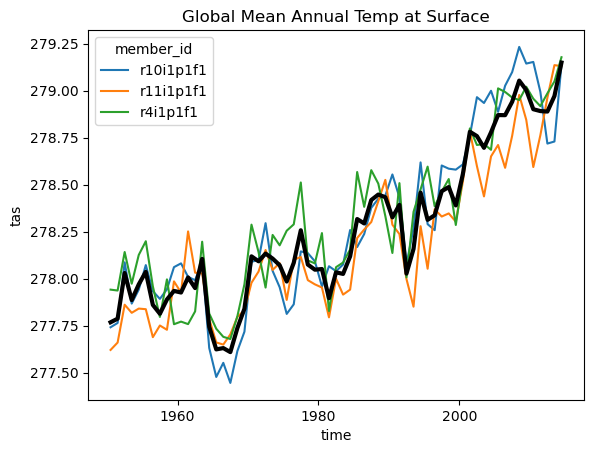

In [36]:
#this time series is Global, sliced in time
#but not space
#used coarsen to make yearly mean 
#for the 1950-2014 slice
#now need to slice in space
mean_temp = tas_hurs_1950_2014_hist.tas.mean(['x', 'y']).coarsen(time=12).mean()
plt.figure()
mean_temp.plot(hue='member_id')
#average over all relizations
mean_temp.mean('member_id').plot(color='k', linewidth=3)
plt.title('Global Mean Annual Temp at Surface',
          fontsize=12,
          color="Black")
plt.show()

In [37]:
#tas_hurs_1950_2014_LA = tas_hurs_1950_2014.sel(lat ="34.05", lon="241.76",method='nearest')

In [38]:
#mean_temp_LA = tas_hurs_1950_2014_LA.tas.mean(['x', 'y']).coarsen(time=12).mean().where((data.lat > 30) & (data.lats < 45) & (data.lons > 240) & (data.lons < 260))
#plt.figure()
#tas_hurs_1950_2014_LA.plot(hue='member_id')
#average over all relizations
#tas_hurs_1950_2014_LA.mean('member_id').plot(color='k', linewidth=3)
#plt.title('LA Mean Annual Temp at Surface',
          #fontsize=12,
          #color="Black")
#plt.show()

In [39]:
tas_hurs_1950_2014_hist.hurs.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [40]:
tas_hurs_1950_2014_hist.hurs.dims

('member_id', 'dcpp_init_year', 'time', 'y', 'x')

In [41]:
tas_hurs_1950_2014_hist.tas.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [42]:
tas_hurs_1950_2014_hist.tas.dims

('member_id', 'dcpp_init_year', 'time', 'y', 'x')

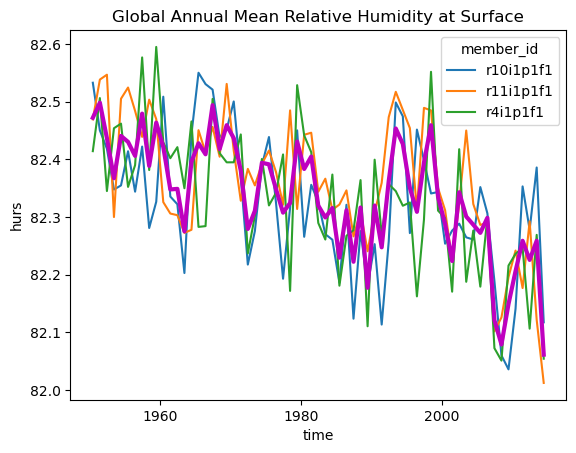

In [43]:
mean_humid = tas_hurs_1950_2014_hist.hurs.mean(['x', 'y']).coarsen(time=12).mean()
plt.figure()
mean_humid.plot(hue='member_id')
#average over all relizations
mean_humid.mean('member_id').plot(color='m', linewidth=3)
plt.title('Global Annual Mean Relative Humidity at Surface',
          fontsize=12,
          color="Black")
plt.show()

In [44]:
tas_hurs_1950_2014_hist.dims

Frozen({'member_id': 3, 'dcpp_init_year': 1, 'time': 780, 'y': 192, 'x': 288, 'nbnd': 2})

In [45]:
tas_hurs_1950_2014_hist.coords["lon"] = tas_hurs_1950_2014_hist.x
tas_hurs_1950_2014_hist.coords["lat"] = tas_hurs_1950_2014_hist.y
tas_hurs_1950_2014_hist.coords["time"] = tas_hurs_1950_2014_hist.time

In [46]:
tas_hurs_1950_2014_hist.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lat             (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [47]:
tas_hurs_1950_2014_hist.lat.values

array([-90.        , -89.05759162, -88.11518325, -87.17277487,
       -86.23036649, -85.28795812, -84.34554974, -83.40314136,
       -82.46073298, -81.51832461, -80.57591623, -79.63350785,
       -78.69109948, -77.7486911 , -76.80628272, -75.86387435,
       -74.92146597, -73.97905759, -73.03664921, -72.09424084,
       -71.15183246, -70.20942408, -69.26701571, -68.32460733,
       -67.38219895, -66.43979058, -65.4973822 , -64.55497382,
       -63.61256545, -62.67015707, -61.72774869, -60.78534031,
       -59.84293194, -58.90052356, -57.95811518, -57.01570681,
       -56.07329843, -55.13089005, -54.18848168, -53.2460733 ,
       -52.30366492, -51.36125654, -50.41884817, -49.47643979,
       -48.53403141, -47.59162304, -46.64921466, -45.70680628,
       -44.76439791, -43.82198953, -42.87958115, -41.93717277,
       -40.9947644 , -40.05235602, -39.10994764, -38.16753927,
       -37.22513089, -36.28272251, -35.34031414, -34.39790576,
       -33.45549738, -32.51308901, -31.57068063, -30.62

In [48]:
tas_hurs_1950_2014_hist.lon.values

array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
        10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
        30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
        40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
        50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
        60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
        70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
        80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
       100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
       110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
       120.  , 121.25, 122.5 , 123.75, 125.  , 126.25, 127.5 , 128.75,
       130.  , 131.25, 132.5 , 133.75, 135.  , 136.25, 137.5 , 138.75,
      

In [49]:
tas_hurs_1950_2014_hist.x.values

array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
        10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
        30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
        40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
        50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
        60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
        70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
        80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
       100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
       110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
       120.  , 121.25, 122.5 , 123.75, 125.  , 126.25, 127.5 , 128.75,
       130.  , 131.25, 132.5 , 133.75, 135.  , 136.25, 137.5 , 138.75,
      

In [50]:
tas_hurs_1950_2014_hist.dims

Frozen({'member_id': 3, 'dcpp_init_year': 1, 'time': 780, 'y': 192, 'x': 288, 'nbnd': 2})

In [51]:
tas_hurs_1950_2014_hist.variable

AttributeError: 'Dataset' object has no attribute 'variable'

In [52]:
tas_hurs_1950_2014_hist.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)


MissingSpatialDimensionError: x dimension (lon) not found.

In [53]:
#tas_hurs_1950_2014.coords["lon"] = ((tas_hurs_1950_2014.coords['lon'] + 180) % 360) - 180
#tas_hurs_1950_2014 = tas_hurs_1950_2014.sortby(["time", "lat", "lon"])

In [54]:
tas_hurs_1950_2014_hist.lon

<xarray.DataArray 'lon' (x: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75])
Coordinates:
  * x        (x) float64 0.0 1.25 2.5 3.75 5.0 ... 353.8 355.0 356.2 357.5 358.8
    lon      (x) float64 0.0 1.25 2.5 3.75 5.0 ... 353.8 355.0 356.2 357.5 358.8
Attributes:
    axis:           X
    bounds:         lon_bnds
    standard_name:  longitude
    title:          Longitude
    type:           double
    valid_max:      360.0
    valid_min:      0.0
    units:          degrees_east

In [55]:
tas_hurs_1950_2014_hist.x

<xarray.DataArray 'x' (x: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75])
Coordinates:
  * x        (x) float64 0.0 1.25 2.5 3.75 5.0 ... 353.8 355.0 356.2 357.5 358.8
    lon      (x) float64 0.0 1.25 2.5 3.75 5.0 ... 353.8 355.0 356.2 357.5 358.8
Attributes:
    axis:           X
    bounds:         lon_bnds
    standard_name:  longitude
    title:          Longitude
    type:           double
    valid_max:      360.0
    valid_min:      0.0
    units:          degrees_east

In [56]:
#from cmip6_preprocessing.preprocessing import combined_preprocessing

In [57]:
#this is the one that works
tas_hurs_dict3 = cat_tas_hurs.to_dataset_dict(
  zarr_kwargs={'consolidated': True, 'use_cftime':True},
  aggregate=True,
  preprocess=combined_preprocessing,
  storage_options={'token': 'anon'}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_34953/2369802888.py:2: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  tas_hurs_dict3 = cat_tas_hurs.to_dataset_dict(


In [58]:
tas_hurs_dict3

{'CMIP.NCAR.CESM2.historical.Amon.gn': <xarray.Dataset>
 Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1980, y: 192,
                      x: 288, nbnd: 2)
 Coordinates:
   * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
   * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
     lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
     lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
     time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * nbnd            (nbnd) int64 0 1
     lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
     lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
   * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
   * dcpp_init_year  (dcpp_init_year) flo

In [59]:
tas_hurs_dict3['CMIP.NCAR.CESM2.historical.Amon.gn']

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1980, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [60]:
tas_hurs_1950_2014_hist = tas_hurs_dict3['CMIP.NCAR.CESM2.historical.Amon.gn'].sel(time=slice("1950","2014"))
    
tas_hurs_1950_2014_hist    
#65yrs = 780months

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 780, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [61]:
print("Time Period start:", tas_hurs_1950_2014_hist.time.min().values)
print("Time Period end:", tas_hurs_1950_2014_hist.time.max().values)

Time Period start: 1950-01-15 12:00:00
Time Period end: 2014-12-15 12:00:00


In [62]:
tas_hurs_1950_2014_hist.dims

Frozen({'member_id': 3, 'dcpp_init_year': 1, 'time': 780, 'y': 192, 'x': 288, 'nbnd': 2})

In [63]:
tas_hurs_1950_2014_hist.coords["lon"] = tas_hurs_1950_2014_hist.lon
tas_hurs_1950_2014_hist.coords["lat"] = tas_hurs_1950_2014_hist.lat
tas_hurs_1950_2014_hist.coords["time"] = tas_hurs_1950_2014_hist.time

In [64]:
tas_hurs_1950_2014_hist.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [65]:
tas_hurs_1950_2014_hist.dims

Frozen({'member_id': 3, 'dcpp_init_year': 1, 'time': 780, 'y': 192, 'x': 288, 'nbnd': 2})

In [66]:
#allocating lon and lat as x and y
#b/c dims and coords need to have the same name
#needed for clipping

#tas_hurs_1950_2014 = tas_hurs_1950_2014.squeeze().transpose('time', 'lat', 'lon')

tas_hurs_1950_2014_hist.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 780, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [67]:
tas_hurs_1950_2014_hist.x.values

array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
        10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
        30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
        40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
        50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
        60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
        70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
        80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
       100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
       110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
       120.  , 121.25, 122.5 , 123.75, 125.  , 126.25, 127.5 , 128.75,
       130.  , 131.25, 132.5 , 133.75, 135.  , 136.25, 137.5 , 138.75,
      

In [68]:
tas_hurs_1950_2014_hist.coords["x"] = ((tas_hurs_1950_2014_hist.coords['x'] + 180) % 360) - 180
tas_hurs_1950_2014_hist = tas_hurs_1950_2014_hist.sortby(["time", "y", "x"])

In [69]:
tas_hurs_1950_2014_hist.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 180.0 180.0 180.0 180.0 ... 178.8 178.8 178.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [70]:
CA_gdf = gpd.read_file("/Users/jenniferbadger/Dropbox/Climatology/Data_new/ca-state-boundary/CA_State_TIGER2016.shp", crs="epsg:4326")

CA_gdf

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,"MULTIPOLYGON (((-13317677.375 3930590.808, -13..."


In [71]:
tas_hurs_1950_2014_hist.rio.write_crs('EPSG:4326', inplace=True)

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 780, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (member_id, y, nbnd, x) float64 -90.0 -90.0 ... 90.0 90.0
    time_bounds     (time, nbnd) object dask.array<chunksize=(780, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 180.0 180.0 180.0 180.0 ... 178.8 178.8 178.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [72]:
clipped_hist = tas_hurs_1950_2014_hist.rio.clip(CA_gdf.geometry.apply(mapping), CA_gdf.crs, all_touched=True)

In [73]:
#here we have less grid cells 
#correct # months
clipped_hist

<xarray.Dataset>
Dimensions:         (y: 11, x: 10, time: 780, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 11, 10), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 11, 10), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [74]:
clipped_hist.x

<xarray.DataArray 'x' (x: 10)>
array([-125.  , -123.75, -122.5 , -121.25, -120.  , -118.75, -117.5 , -116.25,
       -115.  , -113.75])
Coordinates:
  * x            (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [75]:
clipped_hist.y

<xarray.DataArray 'y' (y: 11)>
array([32.513089, 33.455497, 34.397906, 35.340314, 36.282723, 37.225131,
       38.167539, 39.109948, 40.052356, 40.994764, 41.937173])
Coordinates:
  * y            (y) float64 32.51 33.46 34.4 35.34 ... 39.11 40.05 40.99 41.94
    spatial_ref  int64 0
Attributes:
    axis:           Y
    bounds:         lat_bnds
    standard_name:  latitude
    title:          Latitude
    type:           double
    valid_max:      90.0
    valid_min:      -90.0
    units:          degrees_north
    long_name:      latitude

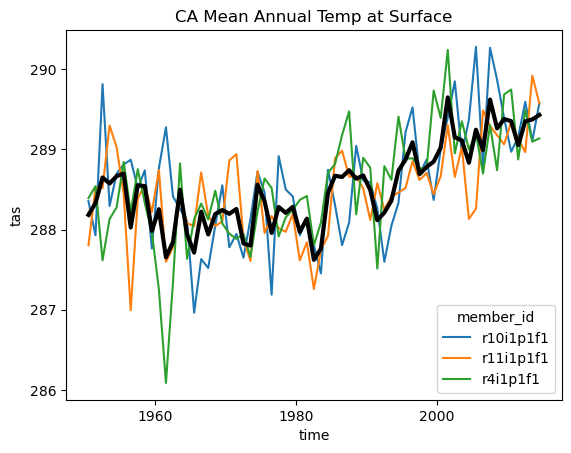

In [76]:
#this time series is 
#sliced in time and space
#used coarsen to make yearly mean 
#for the 1950-2014 slice
#now need to slice in space
mean_temp_CA = clipped_hist.tas.mean(['x', 'y']).coarsen(time=12).mean()
plt.figure()
mean_temp_CA.plot(hue='member_id')
#average over all relizations
mean_temp_CA.mean('member_id').plot(color='k', linewidth=3)
plt.title('CA Mean Annual Temp at Surface',
          fontsize=12,
          color="Black")
plt.show()

#.groupby('time.season').mean('time')

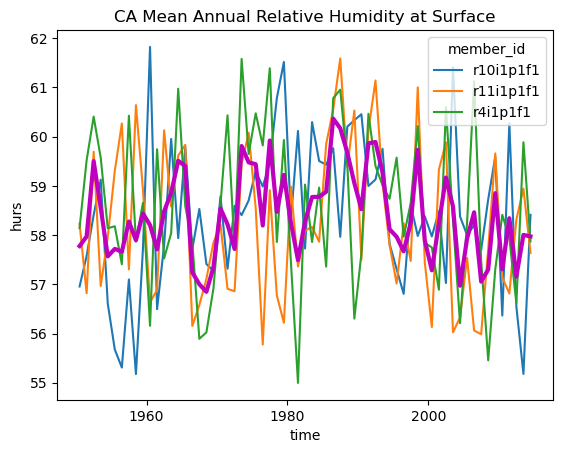

In [85]:
mean_humid_CA = clipped_hist.hurs.mean(['x', 'y']).coarsen(time=12).mean()
plt.figure()
mean_humid_CA.plot(hue='member_id')
#average over all relizations
mean_humid_CA.mean('member_id').plot(color='m', linewidth=3)
plt.title('CA Mean Annual Relative Humidity at Surface',
          fontsize=12,
          color="Black")
plt.show()

In [77]:
#this part isn't actually necessary since the whoe time set is preserved
tas_hurs_1950_2014_ssp245 = tas_hurs_dict3['ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn'].sel(time=slice("2015","2050"))
    
tas_hurs_1950_2014_ssp245    
#36yrs = 432 months b/c includes 

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 432, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, nbnd) object dask.array<chunksize=(432, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 347, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 408, 192, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    contact:                          cesm_cmip6@ucar.edu
    ...                               ...
    intake_esm_attrs:experiment_id:   ssp245
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20200528
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn

In [78]:
print("Time Period start:", tas_hurs_1950_2014_ssp245.time.min().values)
print("Time Period end:", tas_hurs_1950_2014_ssp245.time.max().values)

Time Period start: 2015-01-15 12:00:00
Time Period end: 2050-12-15 12:00:00


In [79]:
tas_hurs_1950_2014_ssp245.dims

Frozen({'member_id': 3, 'dcpp_init_year': 1, 'time': 432, 'y': 192, 'x': 288, 'nbnd': 2})

In [80]:
tas_hurs_1950_2014_ssp245.coords["lon"] = tas_hurs_1950_2014_ssp245.lon
tas_hurs_1950_2014_ssp245.coords["lat"] = tas_hurs_1950_2014_ssp245.lat
tas_hurs_1950_2014_ssp245.coords["time"] = tas_hurs_1950_2014_ssp245.time

In [81]:
tas_hurs_1950_2014_ssp245.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, nbnd) object dask.array<chunksize=(432, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [82]:
tas_hurs_1950_2014_ssp245.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 432, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time            (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, nbnd) object dask.array<chunksize=(432, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 347, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 408, 192, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    contact:                          cesm_cmip6@ucar.edu
    ...                               ...
    intake_esm_attrs:experiment_id:   ssp245
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20200528
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn

In [83]:
tas_hurs_1950_2014_ssp245.coords["x"] = ((tas_hurs_1950_2014_ssp245.coords['x'] + 180) % 360) - 180
tas_hurs_1950_2014_ssp245 = tas_hurs_1950_2014_ssp245.sortby(["time", "y", "x"])

In [84]:
tas_hurs_1950_2014_ssp245.coords

Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * time            (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, nbnd) object dask.array<chunksize=(432, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 180.0 180.0 180.0 180.0 ... 178.8 178.8 178.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan

In [85]:
tas_hurs_1950_2014_ssp245.rio.write_crs('EPSG:4326', inplace=True)

<xarray.Dataset>
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 432, y: 192,
                     x: 288, nbnd: 2)
Coordinates:
  * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * x               (x) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * time            (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    time_bounds     (time, nbnd) object dask.array<chunksize=(432, 2), meta=np.ndarray>
  * nbnd            (nbnd) int64 0 1
    lon             (x, y) float64 180.0 180.0 180.0 180.0 ... 178.8 178.8 178.8
    lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 347, 192, 288), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 408, 192, 288), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    contact:                          cesm_cmip6@ucar.edu
    ...                               ...
    intake_esm_attrs:experiment_id:   ssp245
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20200528
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn

In [86]:
clipped_ssp245 = tas_hurs_1950_2014_ssp245.rio.clip(CA_gdf.geometry.apply(mapping), CA_gdf.crs, all_touched=True)

In [87]:
clipped_ssp245

<xarray.Dataset>
Dimensions:         (y: 11, x: 10, time: 432, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 2015-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 347, 11, 10), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 408, 11, 10), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             735110.0
    branch_time_in_parent:            735110.0
    contact:                          cesm_cmip6@ucar.edu
    ...                               ...
    intake_esm_attrs:experiment_id:   ssp245
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20200528
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn

In [88]:
#next concatenate xr objects w/ xr.concat(); first create time and space slices with 
#['ScenarioMIP.NCAR.CESM2.ssp245.Amon.gn']

tas_hurs_1950_2050 = xr.concat(objs = (clipped_hist, clipped_ssp245), dim='time')

In [89]:
#11 bands of lat, 10 bands of lon
#1212 months = 101 years b/c incl. 1950
tas_hurs_1950_2050 

<xarray.Dataset>
Dimensions:         (y: 11, x: 10, time: 1212, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-01-15 12:00:00 ... 2050-12-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 11, 10), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 11, 10), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    contact:                          cesm_cmip6@ucar.edu
    data_specs_version:               01.00.29
    ...                               ...
    intake_esm_attrs:source_id:       CESM2
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

In [90]:
tas_hurs_1950_2050.tas.attrs['units']

'K'

In [91]:
#https://towardsdatascience.com/xarray-recipes-for-earth-scientists-c12a10c6a293
# assign new variable with kelvin temp.
#tas_hurs_1950_2050 = tas_hurs_1950_2050.assign(temp_c = tas_hurs_1950_2050['tas']-273.15)

# update attributes
#tas_hurs_1950_2050 = tas_hurs_1950_2050['temp_c'].attrs = {'units':'C'}

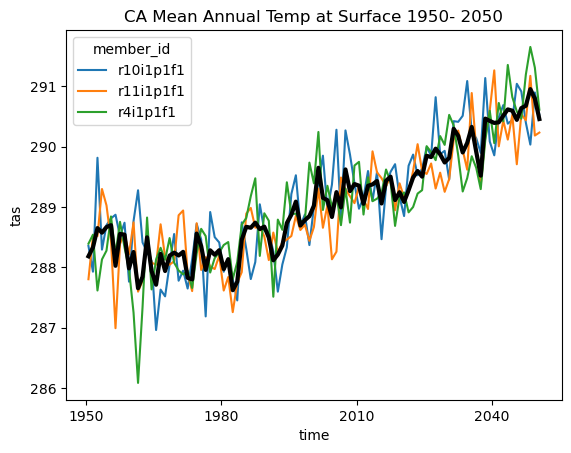

In [92]:
mean_temp_101 = tas_hurs_1950_2050.tas.mean(['x', 'y']).coarsen(time=12).mean()
plt.figure()
mean_temp_101.plot(hue='member_id')
#average over all relizations
mean_temp_101.mean('member_id').plot(color='k', linewidth=3)
plt.title('CA Mean Annual Temp at Surface 1950- 2050',
          fontsize=12,
          color="Black")
plt.show()

In [93]:
#4 seasons
#DJF=Dec-Feb
#MAM=Mar-May
#JJA=Jun-Aug
#SON=Sep-Nov

#Datetime components of the time dimension
#can be accessed directly & used for selecting & grouping.
temp_101_mam = tas_hurs_1950_2050.tas.sel(time=tas_hurs_1950_2050.tas.time.dt.season=="MAM")

#calculate mean per year
#clipped_mam.groupby(clipped_mam.time.dt.year).mean("time")


In [94]:
#This is March-April-May
#averaged across time
#for whole historical period
temp_101_mam.mean("time")

print("Time Period start:", temp_101_mam.time.min().values)
print("Time Period end:", temp_101_mam.time.max().values)

Time Period start: 1950-03-15 12:00:00
Time Period end: 2050-05-15 12:00:00


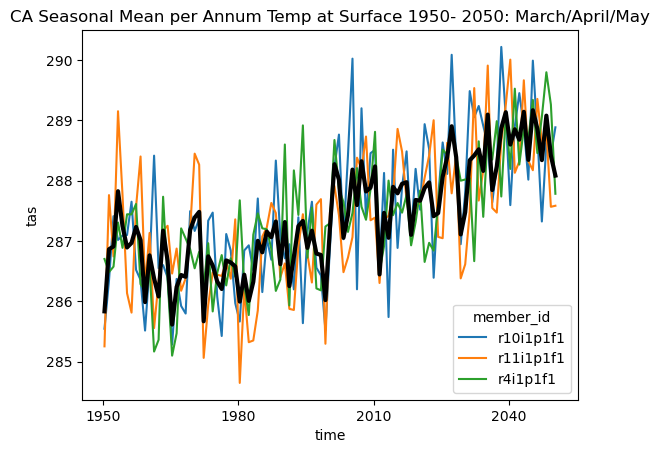

In [95]:
mean_temp_101_mam = temp_101_mam.mean(['x', 'y']).coarsen(time=3).mean()
plt.figure()
mean_temp_101_mam.plot(hue='member_id')
#average over all relizations
mean_temp_101_mam.mean('member_id').plot(color='k', linewidth=3)
plt.title('CA Seasonal Mean per Annum Temp at Surface 1950- 2050: March/April/May',
          fontsize=12,
          color="Black")
plt.show()

In [96]:
temp_101_son = tas_hurs_1950_2050.tas.sel(time=tas_hurs_1950_2050.tas.time.dt.season=="SON")

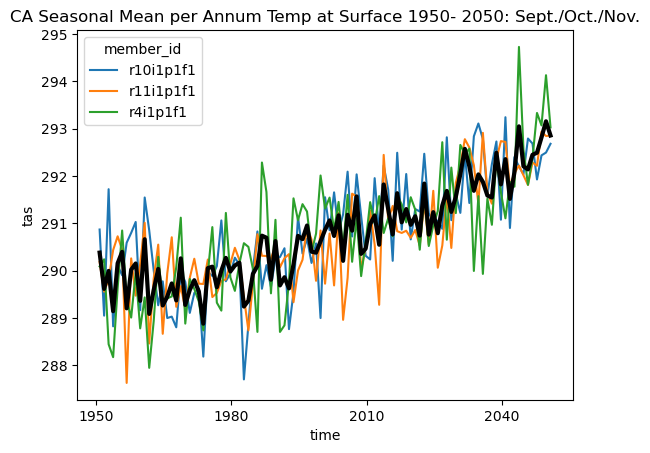

In [97]:
mean_temp_101_son= temp_101_son.mean(['x', 'y']).coarsen(time=3).mean()
plt.figure()
mean_temp_101_son.plot(hue='member_id')
#average over all relizations
mean_temp_101_son.mean('member_id').plot(color='k', linewidth=3)
plt.title('CA Seasonal Mean per Annum Temp at Surface 1950- 2050: Sept./Oct./Nov.',
          fontsize=12,
          color="Black")
plt.show()

In [98]:
hurs_101_mam = tas_hurs_1950_2050.hurs.sel(time=tas_hurs_1950_2050.hurs.time.dt.season=="MAM")

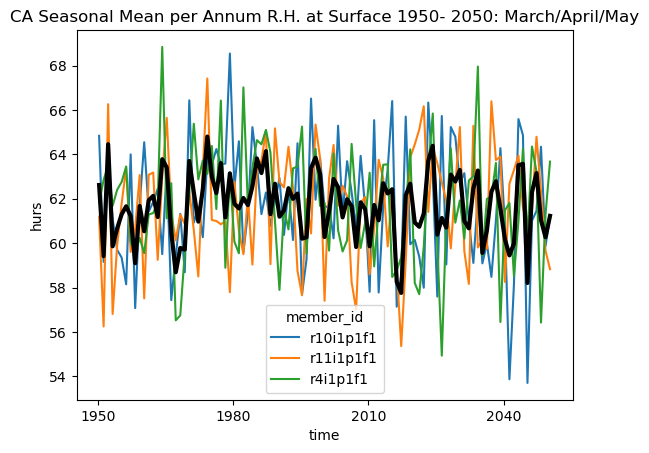

In [99]:
mean_hurs_101_mam = hurs_101_mam.mean(['x', 'y']).coarsen(time=3).mean()
plt.figure()
mean_hurs_101_mam.plot(hue='member_id')
#average over all relizations
mean_hurs_101_mam.mean('member_id').plot(color='k', linewidth=3)
plt.title('CA Seasonal Mean per Annum R.H. at Surface 1950- 2050: March/April/May',
          fontsize=12,
          color="Black")
plt.show()

In [100]:
#303 time slices checks out
#3 months * 101 years
hurs_101_mam

<xarray.DataArray 'hurs' (member_id: 3, dcpp_init_year: 1, time: 303, y: 11,
                          x: 10)>
dask.array<getitem, shape=(3, 1, 303, 11, 10), dtype=float32, chunksize=(1, 1, 150, 11, 10), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    This is the relative humidity with respect to liquid wate...
    frequency:      mon
    id:             hurs
    long_name:      Near-Surface Relative Humidity
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Relative Humidity
    type:           real
    variable_id:    hurs
    units:          %

In [101]:
#303 slices b/c this is w/o time=coarsen
hurs_101_mam.mean('member_id')

<xarray.DataArray 'hurs' (dcpp_init_year: 1, time: 303, y: 11, x: 10)>
dask.array<mean_agg-aggregate, shape=(1, 303, 11, 10), dtype=float32, chunksize=(1, 150, 11, 10), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [102]:
#101 time slices b/c its a seasonal mean
#ie mean[x,y] with time=3
#this is the black line in above plot
#datapoints= mean of all 3 realizations
#at each time step
mean_hurs_101_mam.mean('member_id')

<xarray.DataArray 'hurs' (dcpp_init_year: 1, time: 101)>
dask.array<mean_agg-aggregate, shape=(1, 101), dtype=float32, chunksize=(1, 50), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 1950-04-15 00:00:00 ... 2050-04-15 00:00:00
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [103]:
mean_hurs_101_mam.mean('member_id').values

array([[62.619976, 59.415527, 64.45879 , 59.858032, 60.664402, 61.300785,
        61.661953, 61.223476, 59.094334, 61.67364 , 60.536335, 61.933537,
        62.130512, 61.178005, 63.782623, 63.40732 , 60.49585 , 58.690235,
        59.78482 , 59.710392, 63.703293, 62.29944 , 60.971684, 62.4326  ,
        64.80365 , 62.985073, 62.25961 , 63.60745 , 61.157772, 63.146656,
        61.77949 , 61.56326 , 62.035217, 61.717403, 62.55673 , 63.818027,
        63.159466, 64.146935, 61.30383 , 62.676224, 61.192608, 61.47398 ,
        62.477726, 61.998   , 62.233185, 60.20254 , 60.26474 , 63.387463,
        63.84973 , 63.115376, 60.27536 , 61.426525, 62.89336 , 62.52255 ,
        61.161274, 61.977737, 61.670284, 59.828094, 61.84039 , 61.531147,
        59.85941 , 61.720127, 61.032917, 62.700092, 62.239887, 62.42987 ,
        58.258137, 57.759235, 62.157795, 62.68051 , 60.934193, 60.73679 ,
        61.332798, 63.71512 , 64.38546 , 60.38385 , 61.135483, 60.70368 ,
        63.090973, 62.777695, 63.29924

In [104]:
mean_hurs_101_mam.mean('member_id').values[:1]

array([[62.619976, 59.415527, 64.45879 , 59.858032, 60.664402, 61.300785,
        61.661953, 61.223476, 59.094334, 61.67364 , 60.536335, 61.933537,
        62.130512, 61.178005, 63.782623, 63.40732 , 60.49585 , 58.690235,
        59.78482 , 59.710392, 63.703293, 62.29944 , 60.971684, 62.4326  ,
        64.80365 , 62.985073, 62.25961 , 63.60745 , 61.157772, 63.146656,
        61.77949 , 61.56326 , 62.035217, 61.717403, 62.55673 , 63.818027,
        63.159466, 64.146935, 61.30383 , 62.676224, 61.192608, 61.47398 ,
        62.477726, 61.998   , 62.233185, 60.20254 , 60.26474 , 63.387463,
        63.84973 , 63.115376, 60.27536 , 61.426525, 62.89336 , 62.52255 ,
        61.161274, 61.977737, 61.670284, 59.828094, 61.84039 , 61.531147,
        59.85941 , 61.720127, 61.032917, 62.700092, 62.239887, 62.42987 ,
        58.258137, 57.759235, 62.157795, 62.68051 , 60.934193, 60.73679 ,
        61.332798, 63.71512 , 64.38546 , 60.38385 , 61.135483, 60.70368 ,
        63.090973, 62.777695, 63.29924

In [105]:
mean_hurs_101_mam.mean('member_id').values[0:0]

array([], shape=(0, 101), dtype=float32)

In [129]:
mean_hurs_101_mam.mean('member_id').values[0]

array([62.619976, 59.415527, 64.45879 , 59.858032, 60.664402, 61.300785,
       61.661953, 61.223476, 59.094334, 61.67364 , 60.536335, 61.933537,
       62.130512, 61.178005, 63.782623, 63.40732 , 60.49585 , 58.690235,
       59.78482 , 59.710392, 63.703293, 62.29944 , 60.971684, 62.4326  ,
       64.80365 , 62.985073, 62.25961 , 63.60745 , 61.157772, 63.146656,
       61.77949 , 61.56326 , 62.035217, 61.717403, 62.55673 , 63.818027,
       63.159466, 64.146935, 61.30383 , 62.676224, 61.192608, 61.47398 ,
       62.477726, 61.998   , 62.233185, 60.20254 , 60.26474 , 63.387463,
       63.84973 , 63.115376, 60.27536 , 61.426525, 62.89336 , 62.52255 ,
       61.161274, 61.977737, 61.670284, 59.828094, 61.84039 , 61.531147,
       59.85941 , 61.720127, 61.032917, 62.700092, 62.239887, 62.42987 ,
       58.258137, 57.759235, 62.157795, 62.68051 , 60.934193, 60.73679 ,
       61.332798, 63.71512 , 64.38546 , 60.38385 , 61.135483, 60.70368 ,
       63.090973, 62.777695, 63.299244, 60.99796 , 

In [106]:
#0
#len(mean_hurs_101_mam.mean('member_id').values[:,1])

#1
#len(mean_hurs_101_mam.mean('member_id').values[:1])

len(mean_hurs_101_mam.mean('member_id').values

SyntaxError: unexpected EOF while parsing (3986375400.py, line 7)

In [107]:
#this is 101 b/c its the seasonal mean per annum
len(mean_hurs_101_mam.mean('member_id').time)

#size of values and time have to match

101

In [108]:
mean_hurs_101_mam.mean('member_id').time

<xarray.DataArray 'time' (time: 101)>
array([cftime.DatetimeNoLeap(1950, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1951, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1952, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1953, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1954, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1955, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1956, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1957, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1959, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1961, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1962, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1963, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1964, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1965, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1966, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1967, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1968, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1969, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1974, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1975, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1976, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1977, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1978, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1981, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1982, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1983, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1984, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1985, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1986, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1987, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1988, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1989, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1990, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1991, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1992, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1993, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1994, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1996, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1998, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2001, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2002, 4, 15, 0, 0, 0, 0, has_year

In [170]:
import sys
# Printing all values of array without truncation
np.set_printoptions(threshold=sys.maxsize)
id = mean_hurs_101_mam.indexes['time']
print(id)

np.set_printoptions(threshold=np.inf)
print(id)

CFTimeIndex([1950-04-15 00:00:00, 1951-04-15 00:00:00, 1952-04-15 00:00:00,
             1953-04-15 00:00:00, 1954-04-15 00:00:00, 1955-04-15 00:00:00,
             1956-04-15 00:00:00, 1957-04-15 00:00:00, 1958-04-15 00:00:00,
             1959-04-15 00:00:00,
             ...
             2041-04-15 00:00:00, 2042-04-15 00:00:00, 2043-04-15 00:00:00,
             2044-04-15 00:00:00, 2045-04-15 00:00:00, 2046-04-15 00:00:00,
             2047-04-15 00:00:00, 2048-04-15 00:00:00, 2049-04-15 00:00:00,
             2050-04-15 00:00:00],
            dtype='object', length=101, calendar='noleap', freq='365D')
CFTimeIndex([1950-04-15 00:00:00, 1951-04-15 00:00:00, 1952-04-15 00:00:00,
             1953-04-15 00:00:00, 1954-04-15 00:00:00, 1955-04-15 00:00:00,
             1956-04-15 00:00:00, 1957-04-15 00:00:00, 1958-04-15 00:00:00,
             1959-04-15 00:00:00,
             ...
             2041-04-15 00:00:00, 2042-04-15 00:00:00, 2043-04-15 00:00:00,
             2044-04-15 00:00:0

In [167]:
mean_hurs_101_mam.mean('member_id')

<xarray.DataArray 'hurs' (dcpp_init_year: 1, time: 101)>
dask.array<mean_agg-aggregate, shape=(1, 101), dtype=float32, chunksize=(1, 50), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 1950-04-15 00:00:00 ... 2050-04-15 00:00:00
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0

In [112]:
#mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()

In [113]:
mean_hurs_101_mam.mean('member_id').time

<xarray.DataArray 'time' (time: 101)>
array([cftime.DatetimeNoLeap(1950, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1951, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1952, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1953, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1954, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1955, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1956, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1957, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1959, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1961, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1962, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1963, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1964, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1965, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1966, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1967, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1968, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1969, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1974, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1975, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1976, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1977, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1978, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1981, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1982, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1983, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1984, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1985, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1986, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1987, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1988, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1989, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1990, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1991, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1992, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1993, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1994, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1996, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1998, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2001, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2002, 4, 15, 0, 0, 0, 0, has_year

In [114]:
x = mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()
x

/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_34953/4207184260.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  x = mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()


DatetimeIndex(['1950-04-15', '1951-04-15', '1952-04-15', '1953-04-15',
               '1954-04-15', '1955-04-15', '1956-04-15', '1957-04-15',
               '1958-04-15', '1959-04-15',
               ...
               '2041-04-15', '2042-04-15', '2043-04-15', '2044-04-15',
               '2045-04-15', '2046-04-15', '2047-04-15', '2048-04-15',
               '2049-04-15', '2050-04-15'],
              dtype='datetime64[ns]', length=101, freq=None)

In [115]:
mean_hurs_101_mam.mean('member_id').indexes['time']

CFTimeIndex([1950-04-15 00:00:00, 1951-04-15 00:00:00, 1952-04-15 00:00:00,
             1953-04-15 00:00:00, 1954-04-15 00:00:00, 1955-04-15 00:00:00,
             1956-04-15 00:00:00, 1957-04-15 00:00:00, 1958-04-15 00:00:00,
             1959-04-15 00:00:00,
             ...
             2041-04-15 00:00:00, 2042-04-15 00:00:00, 2043-04-15 00:00:00,
             2044-04-15 00:00:00, 2045-04-15 00:00:00, 2046-04-15 00:00:00,
             2047-04-15 00:00:00, 2048-04-15 00:00:00, 2049-04-15 00:00:00,
             2050-04-15 00:00:00],
            dtype='object', length=101, calendar='noleap', freq='365D')

In [122]:
x = np.arange(len(mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()))
y = mean_hurs_101_mam.mean('member_id').values[0]
              
slope, intercept = np.polyfit(x, y, 1)
trendline = slope * x + intercept

/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_34953/279026527.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  x = np.arange(len(mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()))


In [181]:
print(slope)
print(intercept)

-0.0030590583476896075
61.85088199755448


In [117]:
trendline

array([61.850882  , 61.84782294, 61.84476388, 61.84170482, 61.83864576,
       61.83558671, 61.83252765, 61.82946859, 61.82640953, 61.82335047,
       61.82029141, 61.81723236, 61.8141733 , 61.81111424, 61.80805518,
       61.80499612, 61.80193706, 61.79887801, 61.79581895, 61.79275989,
       61.78970083, 61.78664177, 61.78358271, 61.78052366, 61.7774646 ,
       61.77440554, 61.77134648, 61.76828742, 61.76522836, 61.76216931,
       61.75911025, 61.75605119, 61.75299213, 61.74993307, 61.74687401,
       61.74381496, 61.7407559 , 61.73769684, 61.73463778, 61.73157872,
       61.72851966, 61.72546061, 61.72240155, 61.71934249, 61.71628343,
       61.71322437, 61.71016531, 61.70710626, 61.7040472 , 61.70098814,
       61.69792908, 61.69487002, 61.69181096, 61.68875191, 61.68569285,
       61.68263379, 61.67957473, 61.67651567, 61.67345661, 61.67039756,
       61.6673385 , 61.66427944, 61.66122038, 61.65816132, 61.65510226,
       61.6520432 , 61.64898415, 61.64592509, 61.64286603, 61.63

In [126]:
trendline.dtype #float64

dtype('float64')

In [127]:
x.dtype #int64

dtype('int64')

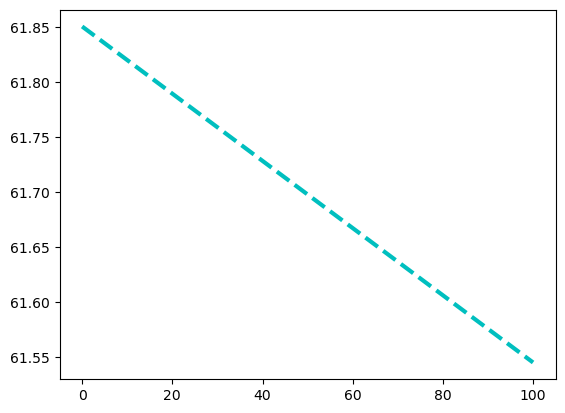

In [118]:
plt.plot(x, trendline, color='c', linestyle='dashed', linewidth=3)

In [147]:
#this doesn't show up on graph
#b/c of 0-100- ie x-axis misalignment
hurs_trend_array = np.vstack((x, trendline)).T
#hurs_trend_array

In [148]:
#next use index points here to create 
#a 2-D array with cftime and trendline hurs
#values using some version of the 
#for loop below
hurs_trend_array[0,1] # 61.850882...
hurs_trend_array[0,0] #0.0
hurs_trend_array[100,1] #61.54497616

len(hurs_trend_array) #101
hurs_trend_array[0] #array([ 0.      , 61.850882])
hurs_trend_array[2, 1] #61.844763880859105
hurs_trend_array[2, 0] #2.0
#array index = [row, col]

hurs_trend_array.shape #(101,2)

(101, 2)

In [143]:
mean_hurs_101_mam.mean('member_id').time[0] #1950
mean_hurs_101_mam.mean('member_id').time[100] #2050

#mean_hurs_101_mam.mean('member_id').shape #(1, 101)
mean_hurs_101_mam.mean('member_id').time

<xarray.DataArray 'time' (time: 101)>
array([cftime.DatetimeNoLeap(1950, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1951, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1952, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1953, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1954, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1955, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1956, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1957, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1958, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1959, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1961, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1962, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1963, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1964, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1965, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1966, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1967, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1968, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1969, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1970, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1974, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1975, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1976, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1977, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1978, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1981, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1982, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1983, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1984, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1985, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1986, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1987, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1988, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1989, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1990, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1991, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1992, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1993, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1994, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1996, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1998, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2001, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2002, 4, 15, 0, 0, 0, 0, has_year

In [158]:
mean_hurs_101_mam.mean

<bound method DataArrayAggregations.mean of <xarray.DataArray 'hurs' (member_id: 3, dcpp_init_year: 1, time: 101)>
dask.array<mean_agg-aggregate, shape=(3, 1, 101), dtype=float32, chunksize=(1, 1, 50), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 1950-04-15 00:00:00 ... 2050-04-15 00:00:00
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0>

In [162]:
#Bowan's code pt 1
#x = tasds126.tas.mean('member_id').resample(time = '1Y').mean().groupby('time.year').mean(...).year
#y = tasds126.tas.mean(['x', 'y']).coarsen(time=12).mean().mean('member_id')

#my adaptation, mean_hurs_101_mam is already in its seasonal mean format
x = hurs_101_mam.mean('member_id').groupby('time.season').mean(...).season
y = hurs_101_mam.mean(['x', 'y']).coarsen(time=3).mean().mean('member_id')
              
#slope, intercept = np.polyfit(x, y, 1)
#trendline = slope * x + intercept

x = x.to_dataframe()
y = y.to_dataframe()

,spatial_ref,season
season,,
MAM,0,MAM


In [165]:
#Bowan's code pt 2
#test = hurs_101_mam.mean(['x', 'y']).coarsen(time=3).mean().mean('member_id').to_dataframe()
#test.index = list(range(1950,2051))
#test['reg'] = reg[0]
#test

NameError: name 'reg' is not defined

In [166]:
#Bowan's code pt 3
lsq_res = stats.linregress(np.array(x.year).reshape(1,-1), np.array(test).reshape(1,-1))
reg = np.array(x.year).reshape(1,-1) * lsq_res[0] + lsq_res[1]
reg[0].shape

fig, axs = plt.subplots(figsize=(15, 10))
# test = tasds126.tas.mean(['x', 'y']).coarsen(time=12).mean().mean('member_id').to_dataframe()
axs.plot(x.year, y.values)
axs.plot(x.year, reg[0], color = 'k')

#uninitialized variables here
#not sure where they came from.

NameError: name 'stats' is not defined

In [149]:
#for i in range(0, len(hurs_trend_array)):   
    #hurs_trend_array[i,0] = pd.to_datetime(hurs_trend_array[i,0])
    #hurs_trend_array[i,] = x[i]
#print(hurs_trend_array)

# rerurns error -float() argument must be a string or a number, not 'cftime._cftime.DatetimeNoLeap'

In [ ]:
#mean_hurs_101_mam.mean('member_id').time
#res=[]
#for i in x:
    #if i.startswith("(") and i.endswith(")"):
        #res.append(i)

/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_34953/610181829.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  x = np.arange(len(mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()))
/var/folders/19/knjb5nd52n90p_gwnf3k939c0000gn/T/ipykernel_34953/610181829.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


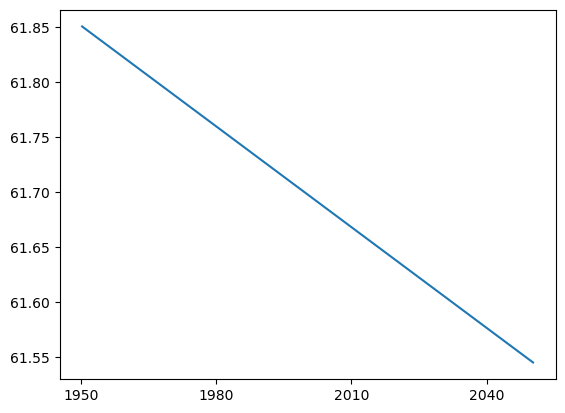

In [172]:
import cftime
import nc_time_axis

fig, ax = plt.subplots(1, 1)

x = np.arange(len(mean_hurs_101_mam.mean('member_id').indexes['time'].to_datetimeindex()))
y = trendline

times = cftime.num2date(x, units="common_years since 1950-04-15", calendar="noleap")

ax.plot(times, y);

fig.show()

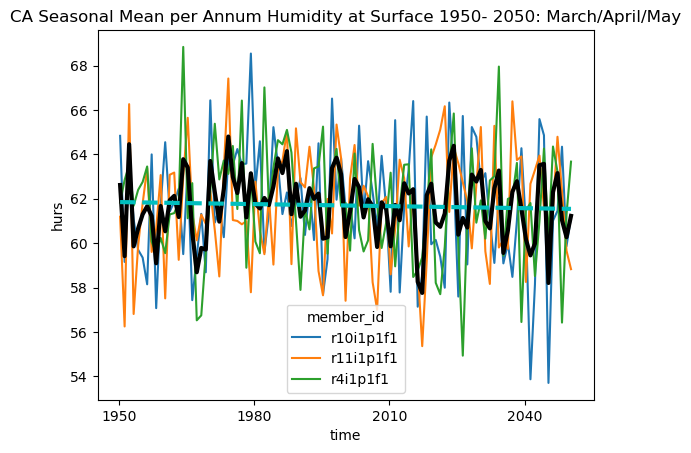

In [175]:
#coarsen(time=3) condenses the March/April/May season 
#into one seasonal mean per year
mean_hurs_101_mam= hurs_101_mam.mean(['x', 'y']).coarsen(time=3).mean()

plt.figure()
mean_hurs_101_mam.plot(hue='member_id')
#average over all relizations
mean_hurs_101_mam.mean('member_id').plot(color='k', linewidth=3)
plt.title('CA Seasonal Mean per Annum Humidity at Surface 1950- 2050: March/April/May',
          fontsize=12,
          color="Black")

#trendline plots!
plt.plot(times, y, color='c', linestyle='dashed', linewidth=3)

#savefig
plt.savefig('/Users/jenniferbadger/Dropbox/Climatology/presentation/CA_hurs_MAM_plot.png', bbox_inches='tight', dpi = 100)

plt.show()

In [176]:
hurs_101_son = tas_hurs_1950_2050.hurs.sel(time=tas_hurs_1950_2050.hurs.time.dt.season=="SON")

In [177]:
mean_hurs_101_son= hurs_101_son.mean(['x', 'y']).coarsen(time=3).mean('member_id')

hurs_son_line = mean_hurs_101_son.polyfit(dim = 'time', deg = 1)

In [178]:
hurs_son_line

<xarray.Dataset>
Dimensions:               (member_id: 3, dcpp_init_year: 0, degree: 2)
Coordinates:
  * member_id             (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year        (dcpp_init_year) float64 
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, member_id, dcpp_init_year) float64 dask.array<chunksize=(2, 3, 0), meta=np.ndarray>

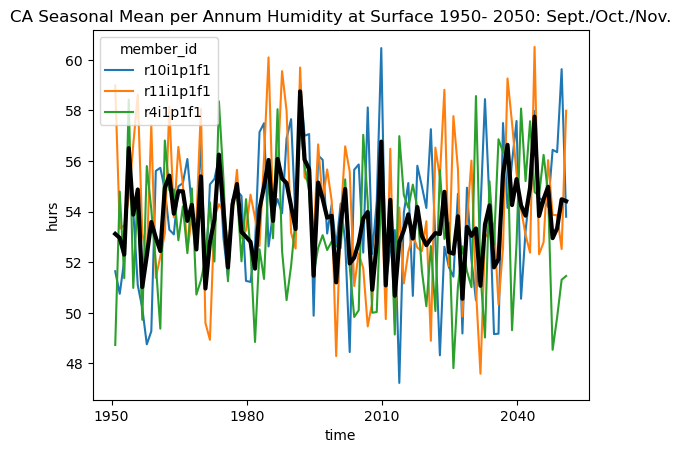

In [168]:
#mean_hurs_101_son= hurs_101_son.mean(['x', 'y']).coarsen(time=3).mean()
plt.figure()
mean_hurs_101_son.plot(hue='member_id')
#average over all relizations
mean_hurs_101_son.mean('member_id').plot(color='k', linewidth=3)
#plt.plot(hurs_son_line)
plt.title('CA Seasonal Mean per Annum Humidity at Surface 1950- 2050: Sept./Oct./Nov.',
          fontsize=12,
          color="Black")
plt.show()

In [179]:
#attempting to export and 
#bring back in these 4 arrays
#for spatial viz
#temp_101_mam
#hurs_101_mam

#temp_101_son
#hurs_101_son

tas_hurs_101_mam = xr.concat(objs = (temp_101_mam, hurs_101_mam), dim='time')

In [180]:
#time is stacked- not what I want
#trying merge next
temp_hurs_101_mam

NameError: name 'temp_hurs_101_mam' is not defined

In [181]:
tas_hurs_101_mam = xr.merge(objects= (temp_101_mam, hurs_101_mam))

In [182]:
temp_101_mam

<xarray.DataArray 'tas' (member_id: 3, dcpp_init_year: 1, time: 303, y: 11,
                         x: 10)>
dask.array<getitem, shape=(3, 1, 303, 11, 10), dtype=float32, chunksize=(1, 1, 150, 11, 10), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [183]:
hurs_101_mam

<xarray.DataArray 'hurs' (member_id: 3, dcpp_init_year: 1, time: 303, y: 11,
                          x: 10)>
dask.array<getitem, shape=(3, 1, 303, 11, 10), dtype=float32, chunksize=(1, 1, 150, 11, 10), chunktype=numpy.ndarray>
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    This is the relative humidity with respect to liquid wate...
    frequency:      mon
    id:             hurs
    long_name:      Near-Surface Relative Humidity
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Relative Humidity
    type:           real
    variable_id:    hurs
    units:          %

In [184]:
#tas and hurs together now
#for march_april_may
#1950-2050
tas_hurs_101_mam

<xarray.Dataset>
Dimensions:         (y: 11, x: 10, time: 303, member_id: 3, dcpp_init_year: 1)
Coordinates:
  * y               (y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * x               (x) float64 -125.0 -123.8 -122.5 ... -116.2 -115.0 -113.8
  * time            (time) object 1950-03-15 12:00:00 ... 2050-05-15 12:00:00
    lon             (x, y) float64 235.0 235.0 235.0 235.0 ... 246.2 246.2 246.2
    lat             (x, y) float64 32.51 33.46 34.4 35.34 ... 40.05 40.99 41.94
  * member_id       (member_id) object 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    spatial_ref     int64 0
Data variables:
    tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 150, 11, 10), meta=np.ndarray>
    hurs            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 150, 11, 10), meta=np.ndarray>
Attributes: (12/18)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    description:    near-surface (usually, 2 meter) air temperature
    frequency:      mon
    id:             tas
    long_name:      Near-Surface Air Temperature
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Near-Surface Air Temperature
    type:           real
    variable_id:    tas
    units:          K

In [185]:
#output MAM as a netcdf
tas_hurs_101_mam_path = '/Users/jenniferbadger/Dropbox/Climatology/net_CDF_products/tas_hurs_101_mam.nc'

tas_hurs_101_mam.to_netcdf(path=tas_hurs_101_mam_path)


#Then in Pro:
#Use "Make NetCDF Raster Layer" tool
#If no projection is showing up use, "Raster Calculator", "Define Projection", and "Project Raster"

In [186]:
#repeat for SON - concat then merge and output

#from previous cell
#hurs_101_son = tas_hurs_1950_2050.hurs.sel(time=tas_hurs_1950_2050.hurs.time.dt.season=="SON")
#creating analogous hurs variable
tas_101_son = tas_hurs_1950_2050.tas.sel(time=tas_hurs_1950_2050.hurs.time.dt.season=="SON")

#merging temp and humidity for sept-oct-nov into one xarray
tas_hurs_101_son = xr.merge(objects= (tas_101_son, hurs_101_son))

#exporting to open in a new notebook
tas_hurs_101_son_path = '/Users/jenniferbadger/Dropbox/Climatology/net_CDF_products/tas_hurs_101_son.nc'
tas_hurs_101_son.to_netcdf(path=tas_hurs_101_son_path)

In [1]:
#import seaborn as sns
#sns.regplot(x=x_data, y=y_data, ci=False, line_kws={'color':'red'});

#calculate equation for trendline
#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)

#add trendline to plot
#plt.plot(x, p(x))

#merge Bight polygons and clip that way
#then output to a netcdf and bring back in for spatial viz

#try upweighting raster cells that are fully inland: 
#this may help: https://docs.xarray.dev/en/stable/user-guide/computation.html
#this will likely help, also uses cosine of latitude
#https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html

#Can try assessing heatwaves and hurs at those time/dims:
#https://gist.github.com/ScottWales/dd9358bea2547c99e46b197bc9f53d21

#next, can try merging my shapefiles and clipping again for one So Cal region
#https://spatial-dev.guru/2022/06/05/merging-multiple-shapefiles-into-one-shapefile-using-python-and-geopandas/

#alternatively, after this is all accomplished, can try downscaling....
#tutorial: https://www.erikkusch.com/courses/krigr/projections/#obtaining-era5-land-data
#Data: 1950 - present temp @ 2m and relative humidty form temp dewpoint
#https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview


#this tutorial has a lot of potential as well
#https://geographicdata.science/book/notebooks/03_spatial_data.html


In [108]:
#Try this next
#https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html

#tas_hurs_1950_2014 = xr.open_mfdataset(files, concat_dim='realization')


In [ ]:
#Try this https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396

In [88]:
#Another way to load cloud data 
#that may work better for spatial subsetting
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [97]:
tas_hurs_df = df.query("activity_id=='CMIP' & source_id ==['CESM2'] & table_id == 'Amon' & variable_id == ['tas', 'hurs'] & experiment_id == ['historical'] & member_id == ['r2i1p1f1', 'r4i1p1f1', 'r10i1p1f1']")
tas_hurs_df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
62691,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
62761,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
63395,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
66341,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
66434,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313


In [98]:
zstore = tas_hurs_df.zstore.values[0:6]
print(zstore)

['gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4i1p1f1/Amon/tas/gn/v20190308/'
 'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2i1p1f1/Amon/tas/gn/v20190308/'
 'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2i1p1f1/Amon/hurs/gn/v20190308/'
 'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4i1p1f1/Amon/hurs/gn/v20190308/'
 'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/'
 'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/hurs/gn/v20190313/']
